In [1]:
import os
import sys
import git
import pathlib

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

PROJ_ROOT_PATH = pathlib.Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
PROJ_ROOT =  str(PROJ_ROOT_PATH)
if PROJ_ROOT not in sys.path:
    sys.path.append(PROJ_ROOT)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

In [3]:
from lib.folder_paths import makeget_logging_dir, get_exp_name_tag, deconstruct_exp_name

In [4]:
model_type_LIST = ["best", "last"]

In [5]:
# Get name of experiments (agents)
env_id = "BankHeistNoFrameskip-v4"
exp_param_type = "noisywarp"
exp_param_value_LIST = [0.0, 0.1, 0.2, 0.3, 0.4]

model_type_LIST = ["best", "last"]


exp_name_LIST = []
for exp_param_value in exp_param_value_LIST:
    # Get names and tags of experiment
    exp_name, exp_metaname, exp_tag = get_exp_name_tag(env_id, exp_param_type, exp_param_value)
    exp_name_LIST.append(exp_name)

NUM_OF_AGENTS = len(exp_name_LIST)
colordict = dict(zip(exp_name_LIST, list(mcolors.TABLEAU_COLORS.keys())))

In [6]:
# Evaluation environment parameters
eval_param_value_LIST = [0.0, 0.1, 0.2, 0.3, 0.4]
NUM_OF_EVAL_ENV = len(eval_param_value_LIST)

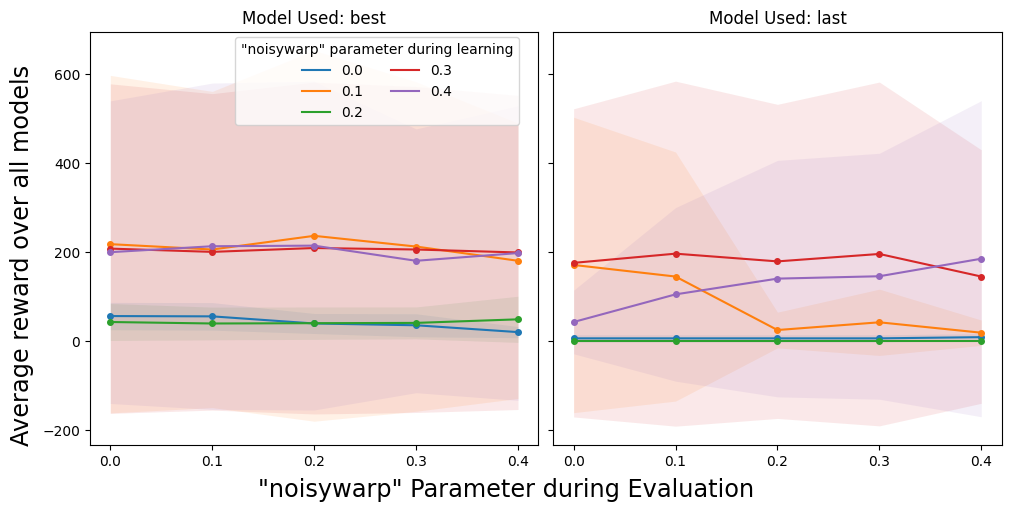

In [7]:
fig_width = 10
fig_height = 5
fig, axes = plt.subplots(nrows=1, 
                         ncols=len(model_type_LIST),
                         figsize=[fig_width,fig_height],
                         sharex=True,sharey=True,
                        layout='constrained')

for col, model_type in enumerate(model_type_LIST):
        
    for exp_name in exp_name_LIST:
        ax = axes[col]
        means=[]
        stds=[]
        avg_reward_mean_std = []
        env_id, exp_param_type, exp_param_value, exp_metaname = deconstruct_exp_name(exp_name)
        eval_param_type = exp_param_type
                
        for eval_param_value in eval_param_value_LIST:
            # Get directories
            models_dir, log_dir, gif_dir, image_dir = makeget_logging_dir(exp_name)
    
            # Get csv filename
            csv_filename = f"{exp_name}--eval_{model_type}-{eval_param_type}_{eval_param_value}.csv"
            csv_file = pathlib.Path(log_dir / csv_filename)
    
            # Read csv
            df = pd.read_csv(csv_file, sep='\t', encoding='utf-8')
    
            # Get global_avg, global_std
            global_avg = np.mean(df["avg"])
            global_std = np.std(df["avg"])

            avg_reward_mean_std.append([global_avg, global_std])

        means = [data[0] for data in avg_reward_mean_std]
        stds = [data[1] for data in avg_reward_mean_std]
        
        err_lim_min = np.array(means) - np.array(stds) 
        err_lim_max = np.array(means) + np.array(stds)
        
        ax.plot(eval_param_value_LIST, means, marker='o', markersize=4,label=f"{exp_param_value}", color = colordict[exp_name])
        ax.fill_between(eval_param_value_LIST, 
                        err_lim_min, err_lim_max, 
                        alpha = 0.1,
                        color = colordict[exp_name],
                        linewidth=0.0)
        ax.set_title(f"Model Used: {model_type}")
        # ax.text(0.8,0.95,
        #         f"Model Used: {model_type}", 
        #         horizontalalignment='center',
        #         verticalalignment='center', 
        #         transform=ax.transAxes)
        ax.set_xticks(ticks=eval_param_value_LIST, labels=eval_param_value_LIST)

legend_elements = [Line2D([0], [0], color=colordict[exp_name]) for exp_name in exp_name_LIST]
fig.legend(handles=legend_elements, 
           labels=ax.get_legend_handles_labels()[1],  
           loc='upper right', 
           bbox_to_anchor=(0.52,0.95),
           ncols=2,#len(exp_name_LIST),
          title=f'"{eval_param_type}" parameter during learning',
          fancybox=True)

fig.supxlabel(f'"{eval_param_type}" Parameter during Evaluation', fontsize='xx-large');
fig.supylabel('Average reward over all models', fontsize='xx-large');

logdir_root = pathlib.Path(PROJ_ROOT_PATH / "logging" / exp_metaname)
filename = f"{env_id}--{exp_tag.split('_')[0]}--all_eval_summary-lineplot.png"
file = pathlib.Path(logdir_root / filename)
fig.savefig(file)